In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

2022-12-02 09:41:13.016071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 09:41:13.116362: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-02 09:41:13.139585: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 09:41:13.561639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config_directory = 'edge_detection_without_prior'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
Model = model.Model(config_path)
DataProcessing = dataset.DataProcessing(Model.cfg["INPUT_SHAPE"], Model.cfg["OUTPUT_SHAPE"], config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.path_definitions()

2022-12-02 09:41:14.701293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 09:41:14.704779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 09:41:14.704874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 09:41:14.705342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

# Load Dataset, Preprocess Images and Dataset

In [3]:
if Model.train_model:
    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

img_only_ds, img_count_img_only_ds = DataProcessing.load_dataset(DataProcessing.key.img_only)

#if Model.train_model:
#    for inp, out in train_ds.take(1):
#        edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
#                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
#                                        num_classes=DataProcessing.num_classes['edge'])

The TEST DS contains 247 images.
The IMG_ONLY DS contains 80 images.


# Define, Compile and Train Model

In [4]:
if Model.train_model:
    model = Model.get_neural_network_model(DataProcessing.num_classes['edge'])
    # model.summary()

    lr = Model.get_lr(img_count_train, DataProcessing.cfg['TRAIN']['BATCH_SIZE'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=Model.get_loss_function(),
                  metrics=Model.get_metrics(DataProcessing.num_classes['edge']))

    history = model.fit(train_ds, epochs=Model.cfg["EPOCHS"], validation_data=train_ds,
                        callbacks=Model.get_callbacks(), verbose=1)

model = Model.get_best_model_from_checkpoints()

/home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=27.97-epoch=80.00-f1=0.6874


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE/assets


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_img (InputLayer)            [(None, 640, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_model (Functional)        [(None, 320, 180, 8  15664       ['in_img[0][0]']                 
                                ),                                                                
                                 (None, 160, 90, 8)                                               
                                , (None, 80, 45, 16                                               
                                )]                                                            

 decoder_2_relu (ReLU)          (None, 80, 45, 15)   0           ['decoder_2_bn[0][0]']           
                                                                                                  
 tf.image.resize_2 (TFOpLambda)  (None, 320, 180, 15  0          ['decoder_2_relu[0][0]']         
                                )                                                                 
                                                                                                  
 side2_1_conv3x3_conv (Conv2D)  (None, 160, 90, 2)   146         ['base_model[0][1]']             
                                                                                                  
 decoder_3_separable_conv (Sepa  (None, 320, 180, 15  375        ['tf.image.resize_2[0][0]']      
 rableConv2D)                   )                                                                 
                                                                                                  
 side1_1_c

                                                                  'side1_conv1x1_conv[0][0]',     
                                                                  'tf.image.resize_3[0][0]']      
                                                                                                  
 concatenate_5 (Concatenate)    (None, 320, 180, 4)  0           ['tf.__operators__.getitem_3[0][0
                                                                 ]',                              
                                                                  'side1_conv1x1_conv[0][0]',     
                                                                  'tf.image.resize_3[0][0]']      
                                                                                                  
 concatenate_6 (Concatenate)    (None, 320, 180, 4)  0           ['tf.__operators__.getitem_4[0][0
                                                                 ]',                              
          

# Plot Results

In [6]:
if Model.train_model:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy", "f1", "recall", "precision"]

    path = os.path.join(Model.Data.paths["FIGURES"], "training.svg")

    plots.plot_training_history(history=history.history, list_of_loss_names=plot_losses,
                                list_of_metric_names=plot_metrics,
                                save=Model.cfg["SAVE"], path=path)

2022-12-02 09:41:35.847329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step


2022-12-02 09:41:36.927801: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


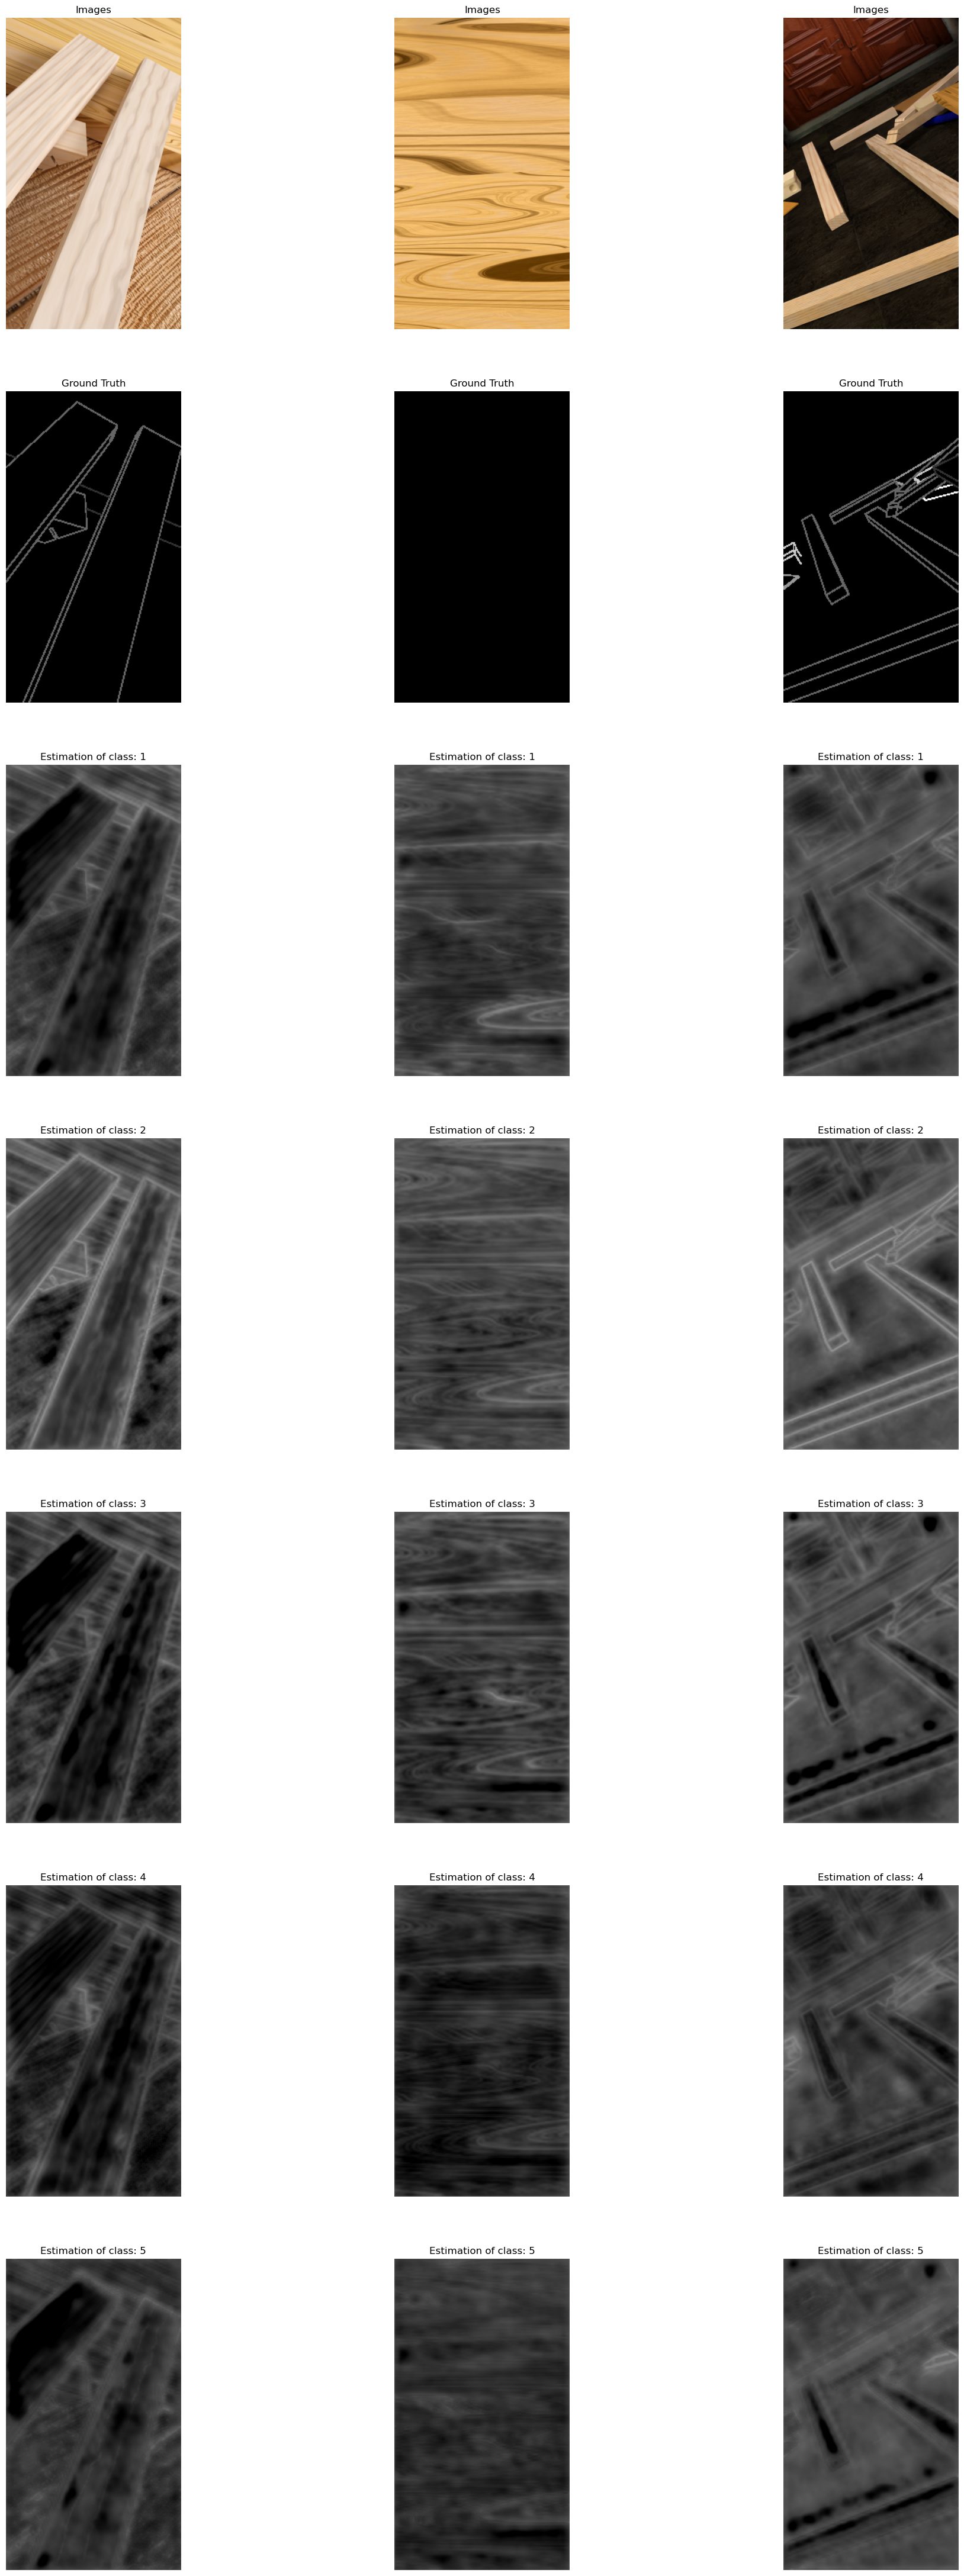

2022-12-02 09:41:38.343410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
                                    predictions=pred,
                                    batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

1/1 [==============================] - 0s 51ms/step


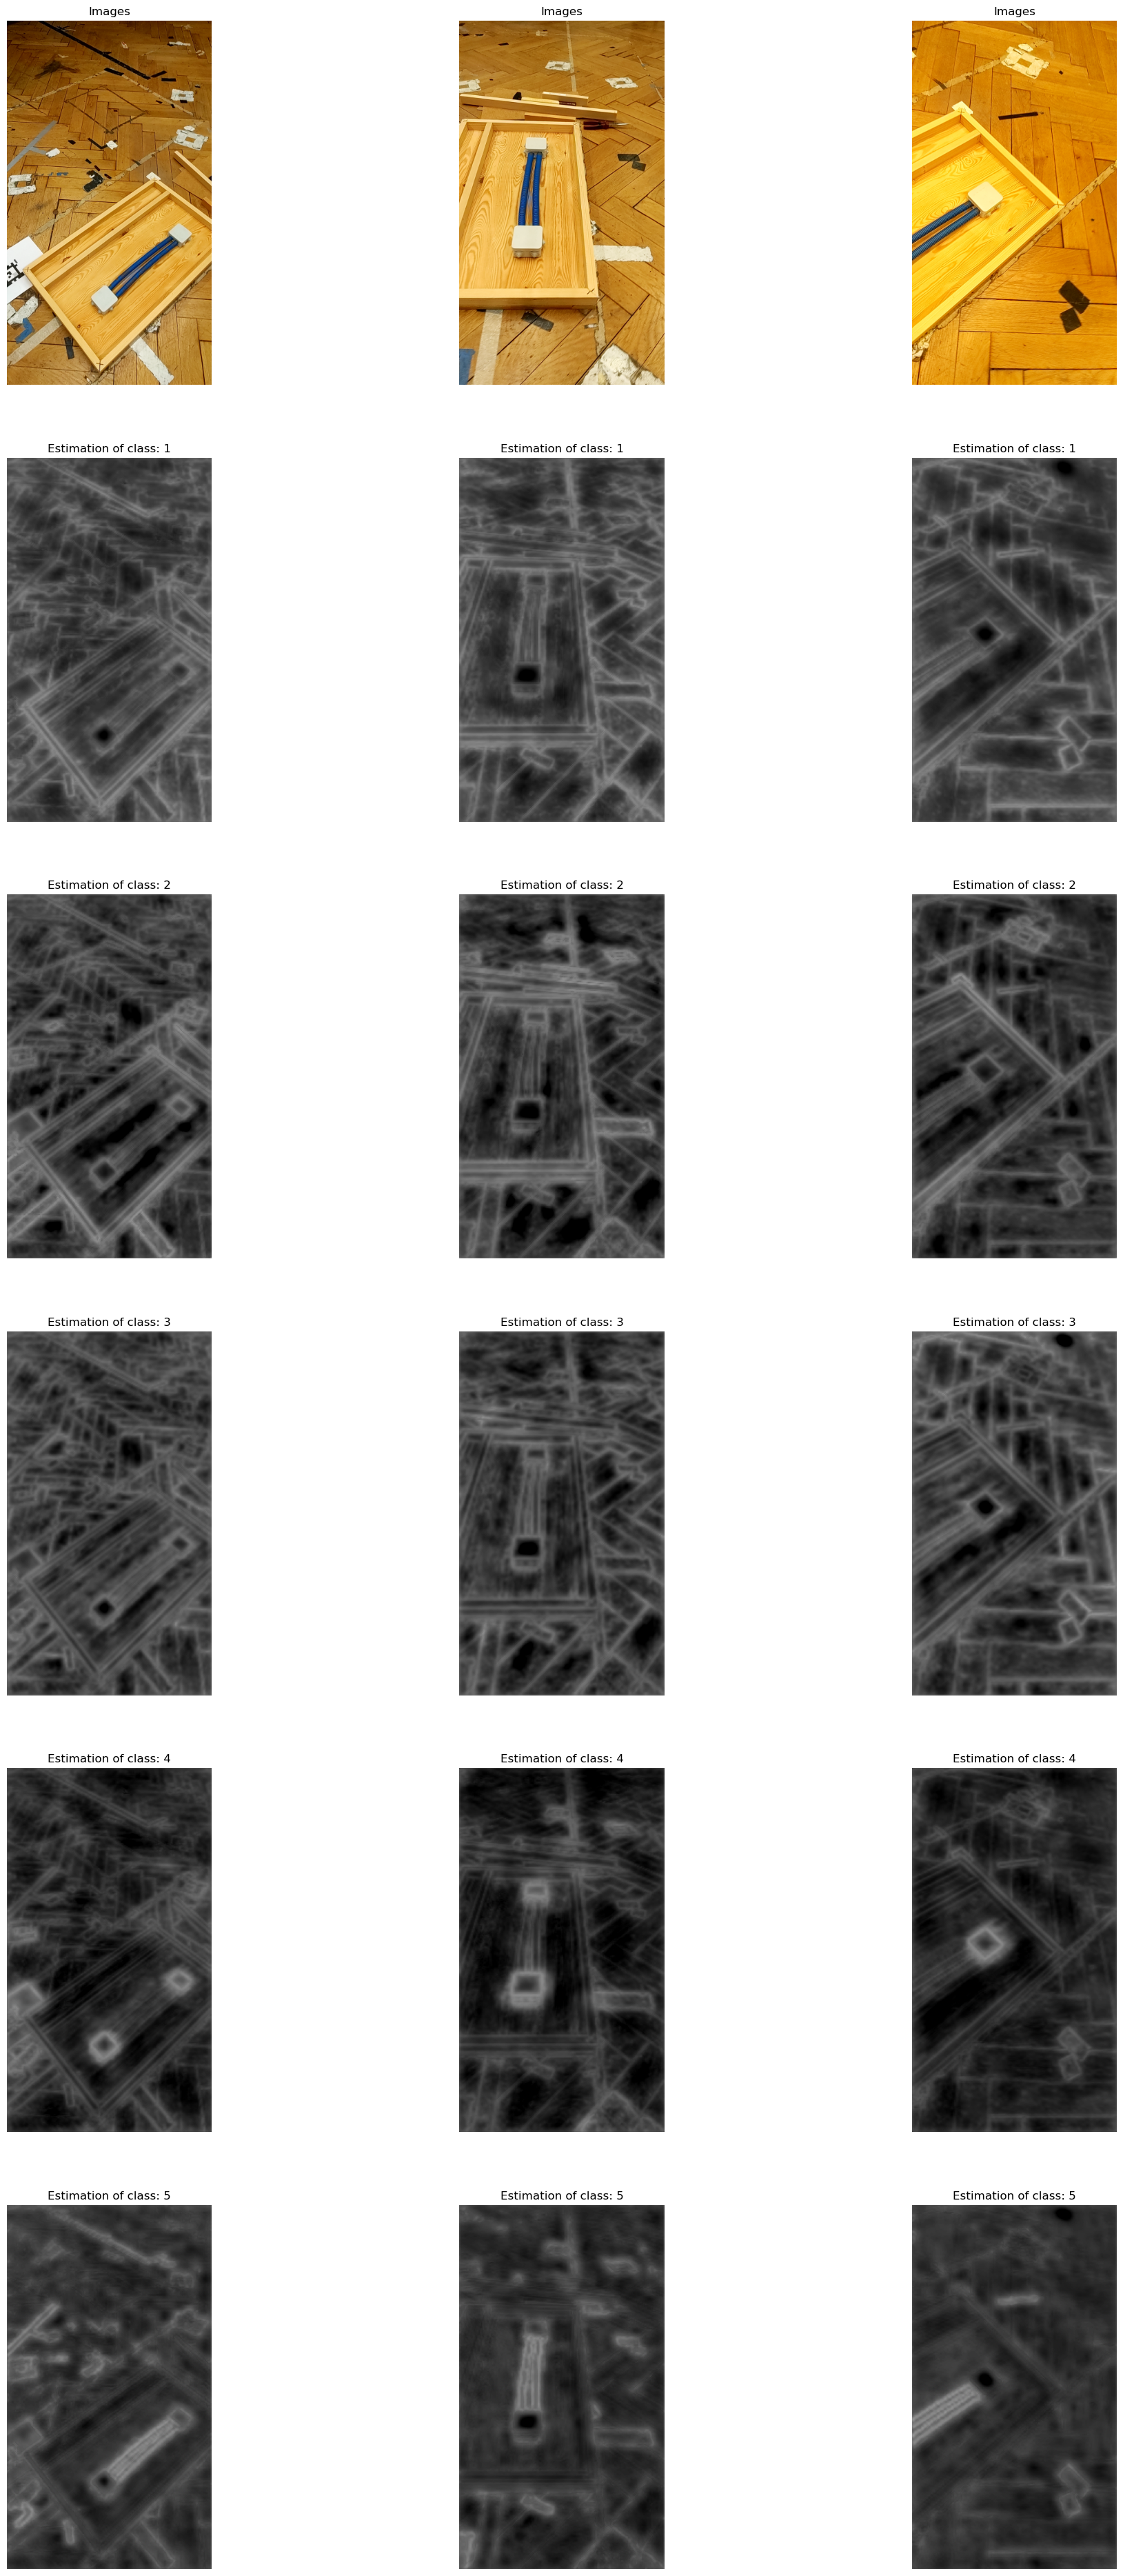

2022-12-02 09:41:39.839349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
for inp, out in img_only_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'],
                                    predictions=pred,
                                    batch_size=DataProcessing.cfg['IMG_ONLY']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

Max Accuracy Score = 0.995 at 0.500
MF1 = 0.672
MF1_1 = 0.572, ODS_1 = 0.400
MF1_2 = 0.711, ODS_2 = 0.400
MF1_3 = 0.685, ODS_3 = 0.500
MF1_4 = 0.507, ODS_4 = 0.400
MF1_5 = 0.701, ODS_5 = 0.500


[0.4, 0.4, 0.5, 0.4, 0.5]

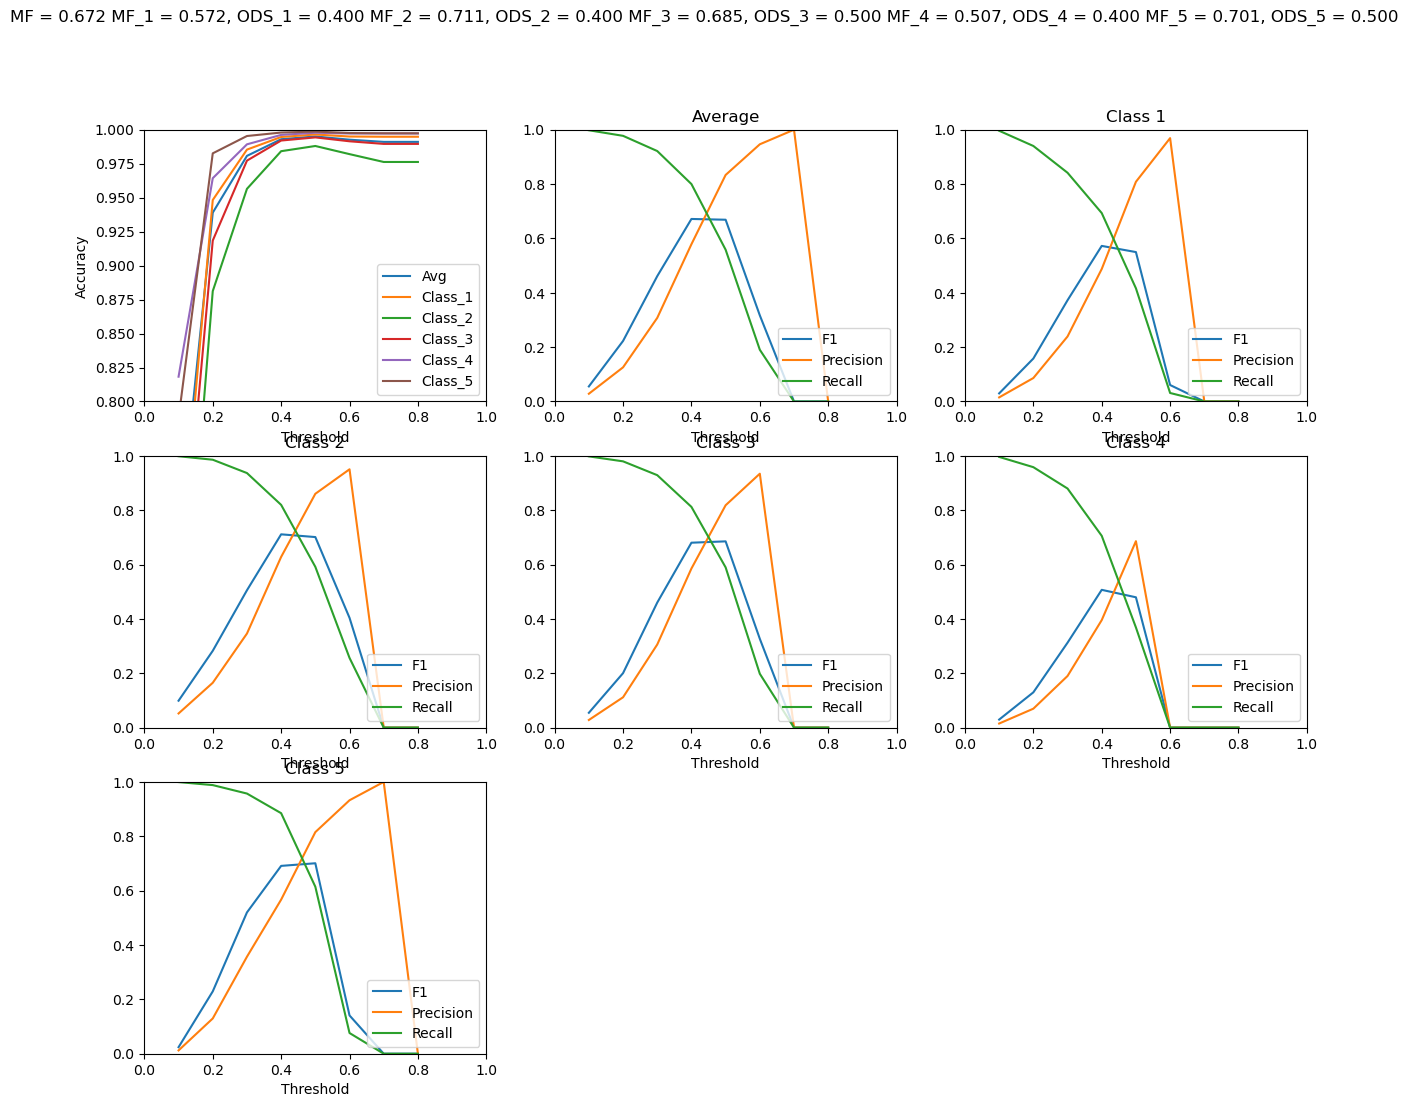

In [9]:
### Maximum F1 Score:
path_metrics_evaluation_plot = os.path.join(Model.Data.paths["FIGURES"],
                                            "threshold_metrics_evaluation_test_ds.svg")

edge_detection_plots.plot_threshold_metrics_evaluation(model=model, ds=test_ds,
                                                       num_classes=DataProcessing.num_classes['edge'],
                                                       classes_displayed_individually=True,
                                                       save=Model.cfg["SAVE"],
                                                       path=path_metrics_evaluation_plot,
                                                       accuracy_y_lim_min=0.8)


In [10]:
if Model.cfg["CONVERT_TO_TFLITE"]:
    Model.convert_model_to_tflite(model)

2022-12-02 09:42:05.057371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-02 09:42:05.057401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-02 09:42:05.058069: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE
2022-12-02 09:42:05.088181: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-02 09:42:05.088217: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE
2022-12-02 09:42:05.152910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-02 09:42:05.177854: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-02 09

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the DEQUANTIZE op takes
tensor #12 as input and produces tensor #106 as output.

Subgraph#0 main(T#0) -> [T#270]
  Op#0 DEQUANTIZE(T#12[]) -> [T#106]
  Op#1 DEQUANTIZE(T#13[]) -> [T#107]
  Op#2 DEQUANTIZE(T#14[]) -> [T#108]
  Op#3 DEQUANTIZE(T#15[]) -> [T#109]
  Op#4 DEQUANTIZE(T#16[]) -> [T#110]
  Op#5 DEQUANTIZE(T#17[]) -> [T#111]
  Op#6 DEQUANTIZE(T#18[]) -> [T#112]
  Op#7 DEQUANTIZE(T#19[]) -> [T#113]
  Op#8 DEQUANTIZE(T#20[]) -> [T#114]
  Op#9 DEQUANTIZE(T#21[]) -> [T#115]
  Op#10 DEQUANTIZE(T#22[]) -> [T#116]
  Op#11 DEQUANTIZE(T#23[]) -> [T#117]
  Op#12 DEQUANTIZE(T#24[]) -> [T#118]
  Op#13 DEQUANTIZE(T#25[]) -> [T#119]
  Op#14 DEQUANTIZE(T#26[]) -> [T#120]
  Op#15 DEQUANTIZE(T#27[]) -> [T#121]
  Op#16 DEQUANTIZE(T#28[]) -> [T#122]
  Op#17 DEQUANTIZE(T#29[]) -> [T#123]
  Op#18 DEQUANTIZE(T#30[]) -> [T#124]
  Op#19 D